In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import emoji
import datetime
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud
from os import path
from PIL import Image
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from textblob import TextBlob
from unidecode import unidecode
import unicodedata

# Twitter Dataset

### Dataset Exploration

In [2]:
twitter = pd.read_excel("twitter.xlsx")
twitter.head()

,title,content,from,locatiion,date,images,url,by,likes,shares
0,NaN,Kalvin Phillips hopeful of World Cup inclusion...,myKhel.com,Bengaluru,2022-11-08 10:40:56,[],https://twitter.com/mykhelcom/status/158981016...,myKhel.com,0,0
1,NaN,Qatar promises a 'carbon-neutral' FIFA World C...,Republic,"Mumbai, India",2022-11-08 10:58:55,[],https://twitter.com/republic/status/1589814697...,Republic,10,1
2,NaN,Qatar's promise of 'carbon-neutral' World Cup ...,Carbon Credit Research,Worldwide,2022-11-08 11:08:09,[],https://twitter.com/CarbonCreditRes/status/158...,Carbon Credit Research,0,0
3,NaN,"Around 6,000 Argentine Fans Banned from Stadiu...",Viral Cyprus,Worldwide,2022-11-08 12:00:50,[],https://twitter.com/viralposthq/status/1589830...,Viral Cyprus,0,0
4,NaN,Happy World Cup Final Day!. Argentina to win 2...,MrX_NFT,NaN,2022-12-18 16:21:57,[],https://twitter.com/MrX__NFT/status/1604391505...,MrX_NFT,0,0


In [3]:
twitter.isna().sum()

title        27508
content          0
from             2
locatiion     8365
date             0
images           0
url              0
by               2
likes            0
shares           0
dtype: int64

In [4]:
twitter.duplicated().sum()

0

In [5]:
twitter['content'].duplicated().sum()

159

In [6]:
twitter = twitter.drop_duplicates(subset='content', keep=False)

twitter

,title,content,from,locatiion,date,images,url,by,likes,shares
0,NaN,Kalvin Phillips hopeful of World Cup inclusion...,myKhel.com,Bengaluru,2022-11-08 10:40:56,[],https://twitter.com/mykhelcom/status/158981016...,myKhel.com,0,0
1,NaN,Qatar promises a 'carbon-neutral' FIFA World C...,Republic,"Mumbai, India",2022-11-08 10:58:55,[],https://twitter.com/republic/status/1589814697...,Republic,10,1
2,NaN,Qatar's promise of 'carbon-neutral' World Cup ...,Carbon Credit Research,Worldwide,2022-11-08 11:08:09,[],https://twitter.com/CarbonCreditRes/status/158...,Carbon Credit Research,0,0
3,NaN,"Around 6,000 Argentine Fans Banned from Stadiu...",Viral Cyprus,Worldwide,2022-11-08 12:00:50,[],https://twitter.com/viralposthq/status/1589830...,Viral Cyprus,0,0
4,NaN,Happy World Cup Final Day!. Argentina to win 2...,MrX_NFT,NaN,2022-12-18 16:21:57,[],https://twitter.com/MrX__NFT/status/1604391505...,MrX_NFT,0,0
...,...,...,...,...,...,...,...,...,...,...
27503,NaN,FIFA World Cup 2022: Sometimes things don’t go...,Daily News hunt 24,Mumbai,2022-11-28 21:24:41,[],https://twitter.com/dailynewshunt24/status/159...,Daily News hunt 24,0,0
27504,NaN,⚽️ FIFA World Cup Qatar 2022 Match schedule:⚽️...,K8 Official,NaN,2022-11-29 03:13:17,[],https://twitter.com/k8official_en/status/15973...,K8 Official,5,1
27505,NaN,Please am I only one that has not yet watched ...,Anas zurmi,Nigeria.,2022-11-29 03:13:26,[],https://twitter.com/zurmacious__jr/status/1597...,Anas zurmi,5,0
27506,NaN,This is what the #FIFAWorldCup is all about;\n...,FIFA World Cup Stats,Global �,2022-11-28 21:47:41,[],https://twitter.com/alimo_philip/status/159722...,FIFA World Cup Stats,124,28


In [7]:
twitter = twitter.drop(columns=["title", "images", "url", "by", "locatiion"]) #Erasing columns

new_column_names = {
    "from": "Publisher",
    "date": "Date",
    "likes": "Likes",
    "shares": "Shares"
}
twitter = twitter.rename(columns=new_column_names)

In [8]:
twitter['Date'] = twitter['Date'].dt.date #Convert to ymd

twitter.head()

,content,Publisher,Date,Likes,Shares
0,Kalvin Phillips hopeful of World Cup inclusion...,myKhel.com,2022-11-08,0,0
1,Qatar promises a 'carbon-neutral' FIFA World C...,Republic,2022-11-08,10,1
2,Qatar's promise of 'carbon-neutral' World Cup ...,Carbon Credit Research,2022-11-08,0,0
3,"Around 6,000 Argentine Fans Banned from Stadiu...",Viral Cyprus,2022-11-08,0,0
4,Happy World Cup Final Day!. Argentina to win 2...,MrX_NFT,2022-12-18,0,0


In [9]:
twitter.dtypes

content      object
Publisher    object
Date         object
Likes         int64
Shares        int64
dtype: object

In [10]:
twitter = twitter.sort_values(by=["Date"])

twitter

,content,Publisher,Date,Likes,Shares
18924,Paul Pogba will miss the Qatar 2022 World Cup ...,World Cup 2022,2022-11-01,12,1
2774,Qatar is facing renewed pressure on migrant wo...,Colossus Diplomacy,2022-11-01,0,0
2775,@PUTERA_Miguel Daniel! How are you? I need y...,Blackburn Roverseasson ��,2022-11-01,0,0
2776,England boss Gareth Southgate says Qatar worke...,SPORTS CIRCUS INT.,2022-11-01,0,0
2777,Mikel Arteta on Thomas Partey: “We have been w...,King David,2022-11-01,0,0
...,...,...,...,...,...
9677,“Dreamers [Music from the FIFA World Cup Qatar...,Jungkook Charts,2023-01-31,75,21
9662,From 700 million years ago to the World Cup: I...,Breaking News,2023-01-31,0,0
9679,Please @Qatar bring back 2022 World Cup,Omar Aldhafiri,2023-01-31,46,10
9661,Lionel Messi has spoken at length following hi...,Mirror Football,2023-01-31,18,4


### Data Analysis

In [11]:
twitter.describe()

,Likes,Shares
count,27256.000000,27256.000000
mean,187.320590,39.446947
std,4962.303879,1535.579967
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,3.000000,1.000000
max,629808.000000,236759.000000


In [12]:
#Likes distribution

likes_percentiles = twitter["Likes"].describe(percentiles=[.50, .60, .70, .75, .80, .85, .90, .95, .96, .97, .98, .99, .995, .999])
print(likes_percentiles)

count     27256.000000
mean        187.320590
std        4962.303879
min           0.000000
50%           0.000000
60%           1.000000
70%           2.000000
75%           3.000000
80%           5.000000
85%          10.000000
90%          23.000000
95%          75.000000
96%         110.000000
97%         175.000000
98%         346.900000
99%        1289.450000
99.5%      4120.500000
99.9%     43300.605000
max      629808.000000
Name: Likes, dtype: float64


In [13]:
#Shares distribution

shares_percentiles = twitter["Shares"].describe(percentiles=[.50, .75, .85, .90, .95, .96, .97, .98, .99, .995, .999])
print(shares_percentiles)

count     27256.000000
mean         39.446947
std        1535.579967
min           0.000000
50%           0.000000
75%           1.000000
85%           3.000000
90%           7.000000
95%          22.000000
96%          31.000000
97%          48.000000
98%          85.000000
99%         366.000000
99.5%      1106.300000
99.9%      7033.615000
max      236759.000000
Name: Shares, dtype: float64


In [14]:
publisher_counts = twitter['Publisher'].value_counts()

publisher_counts.head(10)

Gulf-Times              342
The Voice of America    121
beIN SPORTS             101
#YFM                     89
Metro                    83
Robbie Sparkes           78
AFP news agency          78
Sky News                 68
Andy Vermaut             56
Sadikul Islam            52
Name: Publisher, dtype: int64

In [15]:
print(f"There are {len(twitter['Publisher'].unique())} different people/pages that posted on Twitter in this dataset")

There are 17703 different people/pages that posted on Twitter in this dataset


In [16]:
date_counts = twitter['Date'].value_counts()

date_counts

2022-11-21    2782
2022-11-20    1902
2022-11-19    1318
2022-11-18    1077
2022-11-22     990
              ... 
2023-01-04       4
2023-01-08       3
2023-01-09       3
2023-01-07       2
2023-01-06       1
Name: Date, Length: 92, dtype: int64

In [17]:
twitter_sort_likes = twitter.sort_values(by=['Likes'], ascending=False)

twitter_sort_likes.head()

,content,Publisher,Date,Likes,Shares
11760,방탄소년단 ‘정국’이 2022 FIFA 카타르 월드컵 공식 사운드트랙과 월드컵 개막...,BTS_official,2022-11-12,629808,236759
21390,It’s the end for Cristiano Ronaldo at the Worl...,Fabrizio Romano,2022-12-11,231247,27972
25127,"Lionel Messi: “No, I’m NOT gonna retire from t...",Fabrizio Romano,2022-12-19,184694,16489
11710,"�️ Abdullah Al Nasari, Head of Security at the...",Football Tweet ⚽,2022-11-12,149618,27087
10593,Outrageously disrespectful to Qatar that the B...,Piers Morgan,2022-11-21,133871,21023


In [18]:
twitter_sort_comments = twitter.sort_values(by=['Shares'], ascending=False)

twitter_sort_comments.head()

,content,Publisher,Date,Likes,Shares
11760,방탄소년단 ‘정국’이 2022 FIFA 카타르 월드컵 공식 사운드트랙과 월드컵 개막...,BTS_official,2022-11-12,629808,236759
10585,Jungkook of BTS and Qatari singer Fahad Al Kub...,The Peninsula Qatar,2022-11-20,127116,53379
21390,It’s the end for Cristiano Ronaldo at the Worl...,Fabrizio Romano,2022-12-11,231247,27972
11710,"�️ Abdullah Al Nasari, Head of Security at the...",Football Tweet ⚽,2022-11-12,149618,27087
10593,Outrageously disrespectful to Qatar that the B...,Piers Morgan,2022-11-21,133871,21023


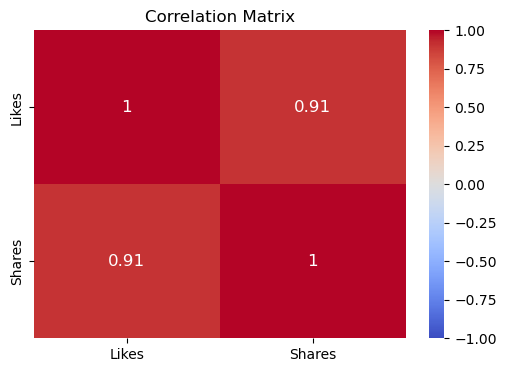

In [19]:
correlation_matrix = twitter.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 12})
plt.title("Correlation Matrix")
plt.show()

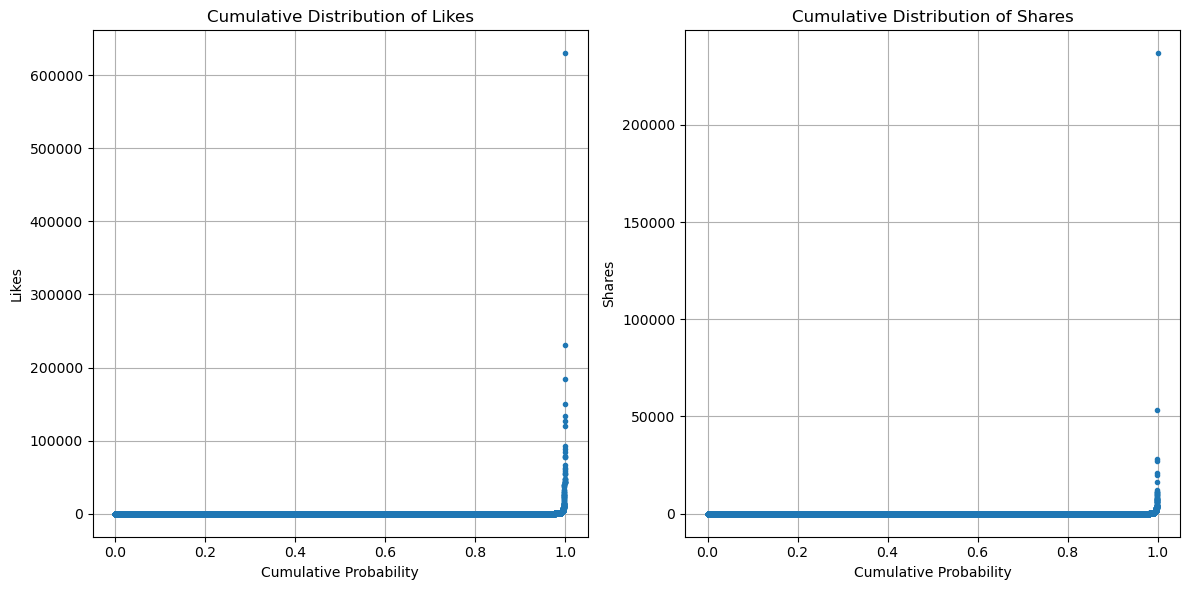

In [20]:
likes_data = twitter["Likes"]
shares_data = twitter["Shares"]

likes_data_sorted = likes_data.sort_values()
shares_data_sorted = shares_data.sort_values()

n = len(likes_data_sorted)
cumulative_distribution_likes = np.arange(1, n + 1) / n
cumulative_distribution_shares = np.arange(1, n + 1) / n

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(cumulative_distribution_likes, likes_data_sorted, marker='.', linestyle='none')
plt.title("Cumulative Distribution of Likes")
plt.xlabel("Cumulative Probability")
plt.ylabel("Likes")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(cumulative_distribution_shares, shares_data_sorted, marker='.', linestyle='none')
plt.title("Cumulative Distribution of Shares")
plt.xlabel("Cumulative Probability")
plt.ylabel("Shares")
plt.grid(True)

plt.tight_layout()
plt.show()

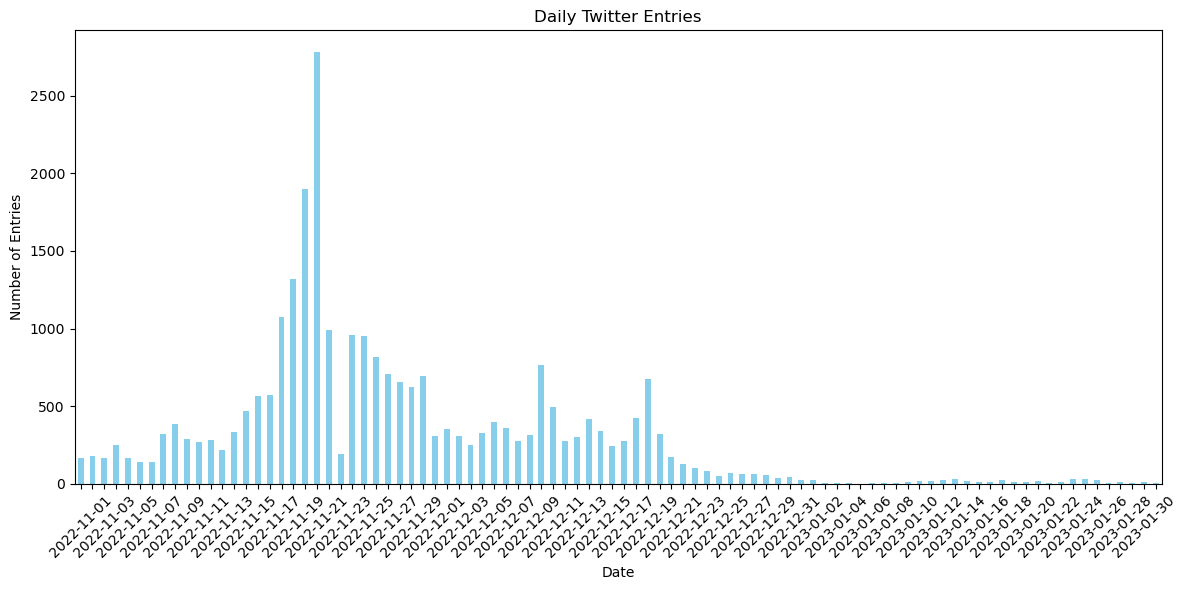

In [21]:
daily_entry_counts = twitter.groupby(twitter["Date"]).size()

plt.figure(figsize=(12, 6))
daily_entry_counts.plot(kind="bar", color="skyblue")
plt.title("Daily Twitter Entries")
plt.xlabel("Date")
plt.ylabel("Number of Entries")
plt.xticks(rotation=45)

x_labels = plt.gca().get_xticklabels()
for i, label in enumerate(x_labels):
    if i % 2 != 0:
        label.set_visible(False)
plt.tight_layout()
plt.show()

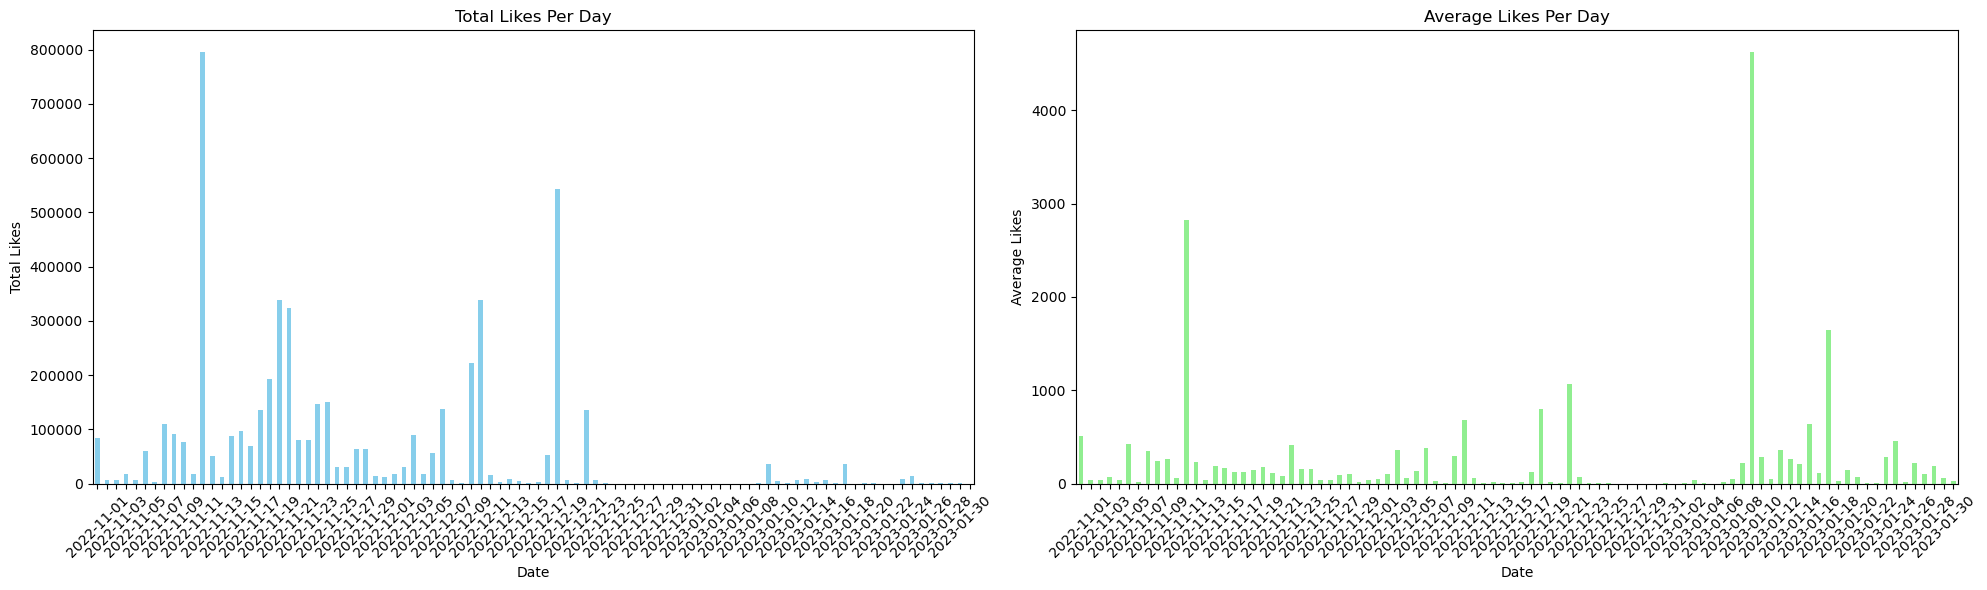

In [22]:
total_likes_per_day = twitter.groupby(twitter["Date"])["Likes"].sum()
average_likes_per_day = twitter.groupby(twitter["Date"])["Likes"].mean()

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)

total_likes_per_day.plot(kind="bar", color="skyblue")
plt.title("Total Likes Per Day")
plt.xlabel("Date")
plt.ylabel("Total Likes")
plt.xticks(rotation=45)

x_labels_total = plt.gca().get_xticklabels()
for i, label in enumerate(x_labels_total):
    if i % 2 != 0:
        label.set_visible(False)

plt.subplot(1, 2, 2)

average_likes_per_day.plot(kind="bar", color="lightgreen")
plt.title("Average Likes Per Day")
plt.xlabel("Date")
plt.ylabel("Average Likes")
plt.xticks(rotation=45)

x_labels_average = plt.gca().get_xticklabels()
for i, label in enumerate(x_labels_average):
    if i % 2 != 0:
        label.set_visible(False)

plt.tight_layout()
plt.show()

/Users/farrelw/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9917 (\N{SOCCER BALL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/farrelw/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 59904 (\uea00) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


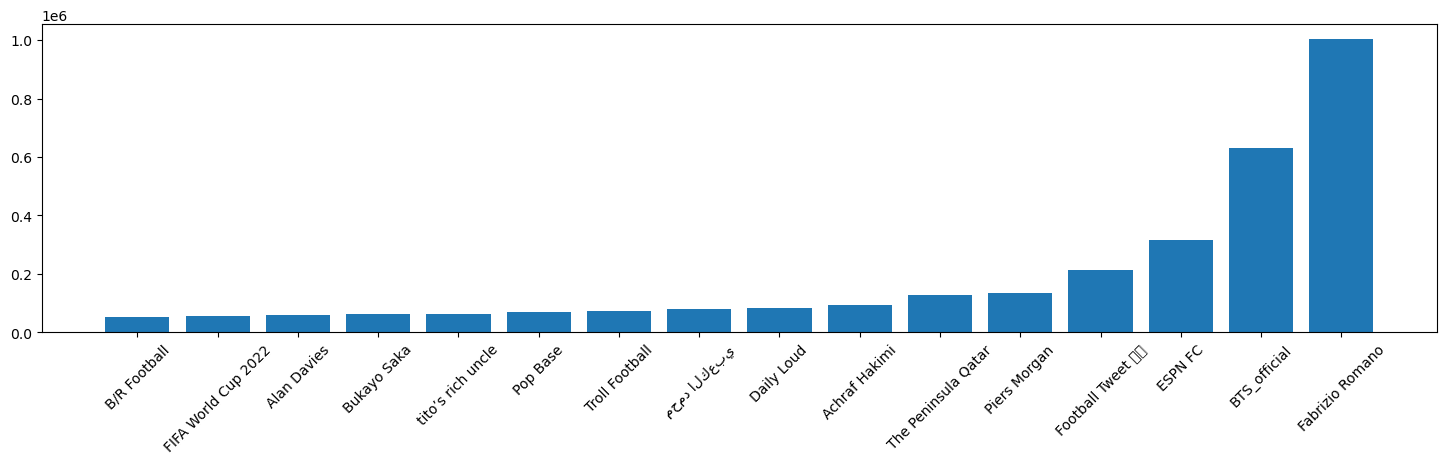

In [23]:
user_likes = twitter.groupby(["Publisher"])["Likes"].sum()
filtered_user_likes = user_likes[user_likes >= 50000]
filtered_user_likes = filtered_user_likes.sort_values()

fig, ax = plt.subplots(figsize=(18, 4))
plt.bar(filtered_user_likes.index, filtered_user_likes.values)
plt.xticks(rotation=45)
plt.show()

/Users/farrelw/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/farrelw/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9917 (\N{SOCCER BALL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/farrelw/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 59904 (\uea00) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


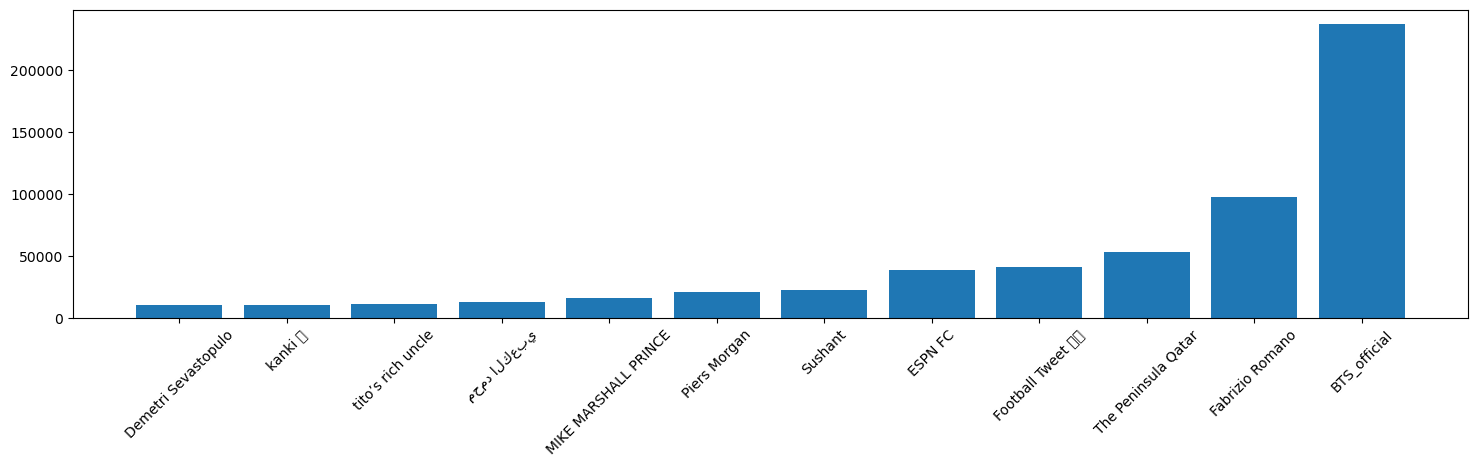

In [24]:
user_com = twitter.groupby("Publisher")["Shares"].sum()
filtered_user_com = user_com[user_com >= 10000]
filtered_user_com = filtered_user_com.sort_values()

fig, ax = plt.subplots(figsize=(18, 4))
plt.bar(filtered_user_com.index, filtered_user_com.values)
plt.xticks(rotation=45)
plt.show()

### NTLK Package

In [25]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))

twitter

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/farrelw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/farrelw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/farrelw/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,content,Publisher,Date,Likes,Shares
18924,Paul Pogba will miss the Qatar 2022 World Cup ...,World Cup 2022,2022-11-01,12,1
2774,Qatar is facing renewed pressure on migrant wo...,Colossus Diplomacy,2022-11-01,0,0
2775,@PUTERA_Miguel Daniel! How are you? I need y...,Blackburn Roverseasson ��,2022-11-01,0,0
2776,England boss Gareth Southgate says Qatar worke...,SPORTS CIRCUS INT.,2022-11-01,0,0
2777,Mikel Arteta on Thomas Partey: “We have been w...,King David,2022-11-01,0,0
...,...,...,...,...,...
9677,“Dreamers [Music from the FIFA World Cup Qatar...,Jungkook Charts,2023-01-31,75,21
9662,From 700 million years ago to the World Cup: I...,Breaking News,2023-01-31,0,0
9679,Please @Qatar bring back 2022 World Cup,Omar Aldhafiri,2023-01-31,46,10
9661,Lionel Messi has spoken at length following hi...,Mirror Football,2023-01-31,18,4


In [26]:
#Eliminates stopwords

twitter['content'] = twitter['content'].apply(lambda text: ' '.join([word for word in word_tokenize(text) if word.lower() not in stop_words]))

twitter

,content,Publisher,Date,Likes,Shares
18924,Paul Pogba miss Qatar 2022 World Cup due new i...,World Cup 2022,2022-11-01,12,1
2774,Qatar facing renewed pressure migrant worker L...,Colossus Diplomacy,2022-11-01,0,0
2775,@ PUTERA_Miguel Daniel ! ? need help . working...,Blackburn Roverseasson ��,2022-11-01,0,0
2776,England boss Gareth Southgate says Qatar worke...,SPORTS CIRCUS INT.,2022-11-01,0,0
2777,Mikel Arteta Thomas Partey : “ waiting ! happe...,King David,2022-11-01,0,0
...,...,...,...,...,...
9677,“ Dreamers [ Music FIFA World Cup Qatar 2022 O...,Jungkook Charts,2023-01-31,75,21
9662,700 million years ago World Cup : Inside Qatar...,Breaking News,2023-01-31,0,0
9679,Please @ Qatar bring back 2022 World Cup,Omar Aldhafiri,2023-01-31,46,10
9661,Lionel Messi spoken length following historic ...,Mirror Football,2023-01-31,18,4


In [27]:
#Remove emojis

df_emoji = pd.DataFrame(twitter)
def remove_emojis(twitter):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"
        u"\u3030"
        u"\u0600-\u06FF"
                      "]+", re.UNICODE)
    return re.sub(emoj, '',twitter)
df_emoji.content=df_emoji['content'].apply(remove_emojis)
df_emoji

,content,Publisher,Date,Likes,Shares
18924,Paul Pogba miss Qatar 2022 World Cup due new i...,World Cup 2022,2022-11-01,12,1
2774,Qatar facing renewed pressure migrant worker L...,Colossus Diplomacy,2022-11-01,0,0
2775,@ PUTERA_Miguel Daniel ! ? need help . working...,Blackburn Roverseasson ��,2022-11-01,0,0
2776,England boss Gareth Southgate says Qatar worke...,SPORTS CIRCUS INT.,2022-11-01,0,0
2777,Mikel Arteta Thomas Partey : “ waiting ! happe...,King David,2022-11-01,0,0
...,...,...,...,...,...
9677,“ Dreamers [ Music FIFA World Cup Qatar 2022 O...,Jungkook Charts,2023-01-31,75,21
9662,700 million years ago World Cup : Inside Qatar...,Breaking News,2023-01-31,0,0
9679,Please @ Qatar bring back 2022 World Cup,Omar Aldhafiri,2023-01-31,46,10
9661,Lionel Messi spoken length following historic ...,Mirror Football,2023-01-31,18,4


In [28]:
#Lemmatization

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = nltk.word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word, pos='v') for word in words]  # Assuming verbs
    return ' '.join(lemmatized_words)

twitter['content'] = twitter['content'].apply(lemmatize_text)

twitter

,content,Publisher,Date,Likes,Shares
18924,Paul Pogba miss Qatar 2022 World Cup due new i...,World Cup 2022,2022-11-01,12,1
2774,Qatar face renew pressure migrant worker LGBT ...,Colossus Diplomacy,2022-11-01,0,0
2775,@ PUTERA_Miguel Daniel ! ? need help . work am...,Blackburn Roverseasson ��,2022-11-01,0,0
2776,England boss Gareth Southgate say Qatar worker...,SPORTS CIRCUS INT.,2022-11-01,0,0
2777,"Mikel Arteta Thomas Partey : “ wait ! happen ,...",King David,2022-11-01,0,0
...,...,...,...,...,...
9677,“ Dreamers [ Music FIFA World Cup Qatar 2022 O...,Jungkook Charts,2023-01-31,75,21
9662,700 million years ago World Cup : Inside Qatar...,Breaking News,2023-01-31,0,0
9679,Please @ Qatar bring back 2022 World Cup,Omar Aldhafiri,2023-01-31,46,10
9661,Lionel Messi speak length follow historic Worl...,Mirror Football,2023-01-31,18,4


In [29]:
#Remove punctuation marks

def remove_punctuation(text):
    return re.sub(r'[^\w\s#]', '', text)

twitter['content'] = twitter['content'].apply(remove_punctuation)
twitter

,content,Publisher,Date,Likes,Shares
18924,Paul Pogba miss Qatar 2022 World Cup due new i...,World Cup 2022,2022-11-01,12,1
2774,Qatar face renew pressure migrant worker LGBT ...,Colossus Diplomacy,2022-11-01,0,0
2775,PUTERA_Miguel Daniel need help work ambiti...,Blackburn Roverseasson ��,2022-11-01,0,0
2776,England boss Gareth Southgate say Qatar worker...,SPORTS CIRCUS INT.,2022-11-01,0,0
2777,Mikel Arteta Thomas Partey wait happen hap...,King David,2022-11-01,0,0
...,...,...,...,...,...
9677,Dreamers Music FIFA World Cup Qatar 2022 Off...,Jungkook Charts,2023-01-31,75,21
9662,700 million years ago World Cup Inside Qatar ...,Breaking News,2023-01-31,0,0
9679,Please Qatar bring back 2022 World Cup,Omar Aldhafiri,2023-01-31,46,10
9661,Lionel Messi speak length follow historic Worl...,Mirror Football,2023-01-31,18,4


In [30]:
def remove_characters(text):
    characters_to_remove = ["``", "`", "'", "’", "“", "'s", "�"]
    for char in characters_to_remove:
        text = text.replace(char, '')
    return text

def remove_words(text):
    words_to_remove = ["FIFA", "fifa", "World", "world", "Cup", "cup", "2022", "FIFA Qatar", "Qatar FIFA", "Qatar World", "Qatar 2022"]
    for words in words_to_remove:
        text = text.replace(words, '')
    return text

def remove_standalone_s(text):
    return re.sub(r'\bs\b', ' ', text)

def merge_hashtags(text):
    return re.sub(r'#\s', '#', text)

def extract_hashtags(text):
    hashtags = [tag for tag in text.split() if tag.startswith('#')]
    return ' '.join([word for word in text.split() if not word.startswith('#')]), ' '.join(hashtags)

def remove_links(text):
    # Use regular expression to remove URLs
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

twitter['content'] = twitter['content'].apply(remove_characters)
twitter['content'] = twitter['content'].apply(remove_words)
twitter['content'] = twitter['content'].apply(remove_standalone_s)
twitter['content'] = twitter['content'].apply(merge_hashtags)
twitter['content'] = twitter['content'].apply(remove_links)


twitter['content'] = twitter['content'].str.replace('FIFA World Cup', 'FIFAWorldCup')
twitter['content'] = twitter['content'].str.replace('World Cup', 'WorldCup')
twitter['Publisher'] = twitter['Publisher'].str.replace('�', '')

twitter = twitter[twitter['content'].apply(lambda tokens: 'RT' not in tokens)]
twitter[['content', 'Hashtag']] = twitter['content'].apply(extract_hashtags).apply(pd.Series)

twitter

/var/folders/90/8rv49pjx7111pvk_g8scvky40000gn/T/ipykernel_6814/3884616890.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter[['content', 'Hashtag']] = twitter['content'].apply(extract_hashtags).apply(pd.Series)
/var/folders/90/8rv49pjx7111pvk_g8scvky40000gn/T/ipykernel_6814/3884616890.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter[['content', 'Hashtag']] = twitter['content'].apply(extract_hashtags).apply(pd.Series)


,content,Publisher,Date,Likes,Shares,Hashtag
18924,Paul Pogba miss Qatar due new injury confirm a...,World Cup 2022,2022-11-01,12,1,#Pogba
2774,Qatar face renew pressure migrant worker LGBT ...,Colossus Diplomacy,2022-11-01,0,0,
2775,PUTERA_Miguel Daniel need help work ambitious ...,Blackburn Roverseasson,2022-11-01,0,0,
2776,England boss Gareth Southgate say Qatar worker...,SPORTS CIRCUS INT.,2022-11-01,0,0,
2777,Mikel Arteta Thomas Partey wait happen happy h...,King David,2022-11-01,0,0,
...,...,...,...,...,...,...
9677,Dreamers Music Qatar Official Soundtrack Jung ...,Jungkook Charts,2023-01-31,75,21,#118
9662,700 million years ago Inside Qatar best museum...,Breaking News,2023-01-31,0,0,
9679,Please Qatar bring back,Omar Aldhafiri,2023-01-31,46,10,
9661,Lionel Messi speak length follow historic succ...,Mirror Football,2023-01-31,18,4,


In [31]:
twitter.head(290)

,content,Publisher,Date,Likes,Shares,Hashtag
18924,Paul Pogba miss Qatar due new injury confirm a...,World Cup 2022,2022-11-01,12,1,#Pogba
2774,Qatar face renew pressure migrant worker LGBT ...,Colossus Diplomacy,2022-11-01,0,0,
2775,PUTERA_Miguel Daniel need help work ambitious ...,Blackburn Roverseasson,2022-11-01,0,0,
2776,England boss Gareth Southgate say Qatar worker...,SPORTS CIRCUS INT.,2022-11-01,0,0,
2777,Mikel Arteta Thomas Partey wait happen happy h...,King David,2022-11-01,0,0,
...,...,...,...,...,...,...
12738,six top spot eat Qatar Arabic specialties monu...,Bloomberg,2022-11-02,19,6,
12739,SoccerUnited States hope put demons behind Qat...,Channel NewsAsia,2022-11-02,2,0,
13645,Champions tcohkCxkMlbh7,Amro Alsoultan,2022-11-02,2,0,#___ #__ #Roads
11820,Cryptocom surpass 70 million users Cryptocom p...,$QOM Shiba Predator,2022-11-02,0,0,


### WordCloud

(-0.5, 599.5, 399.5, -0.5)

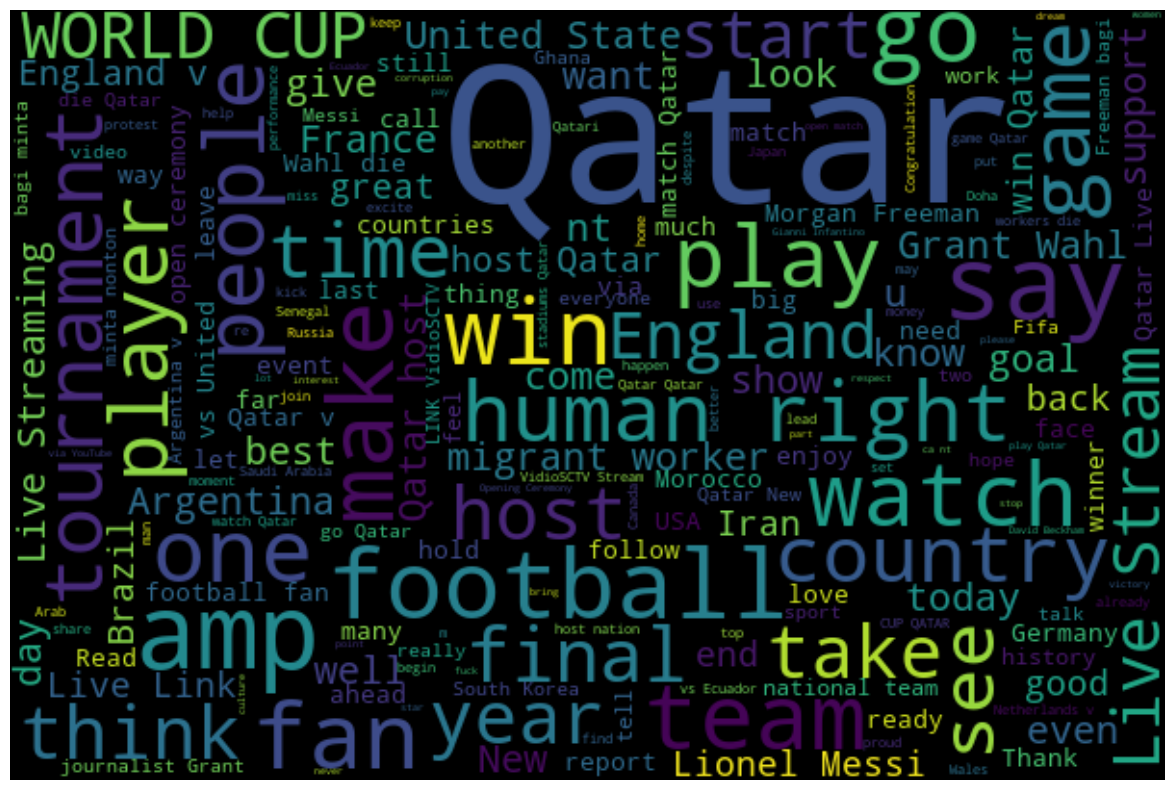

In [32]:
wordcloud = WordCloud(
    width=600,
    height=400,
    random_state=1,
)
data = twitter['content']
text_data = ' '.join(data)
wordcloud.generate(text_data)
wordcloud.to_image()

all_words_lem = ' '.join([word for word in twitter['content']])

wordcloud = WordCloud(width=600, 
                     height=400, 
                     random_state=1, 
                     max_font_size=100).generate(all_words_lem)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

(-0.5, 599.5, 399.5, -0.5)

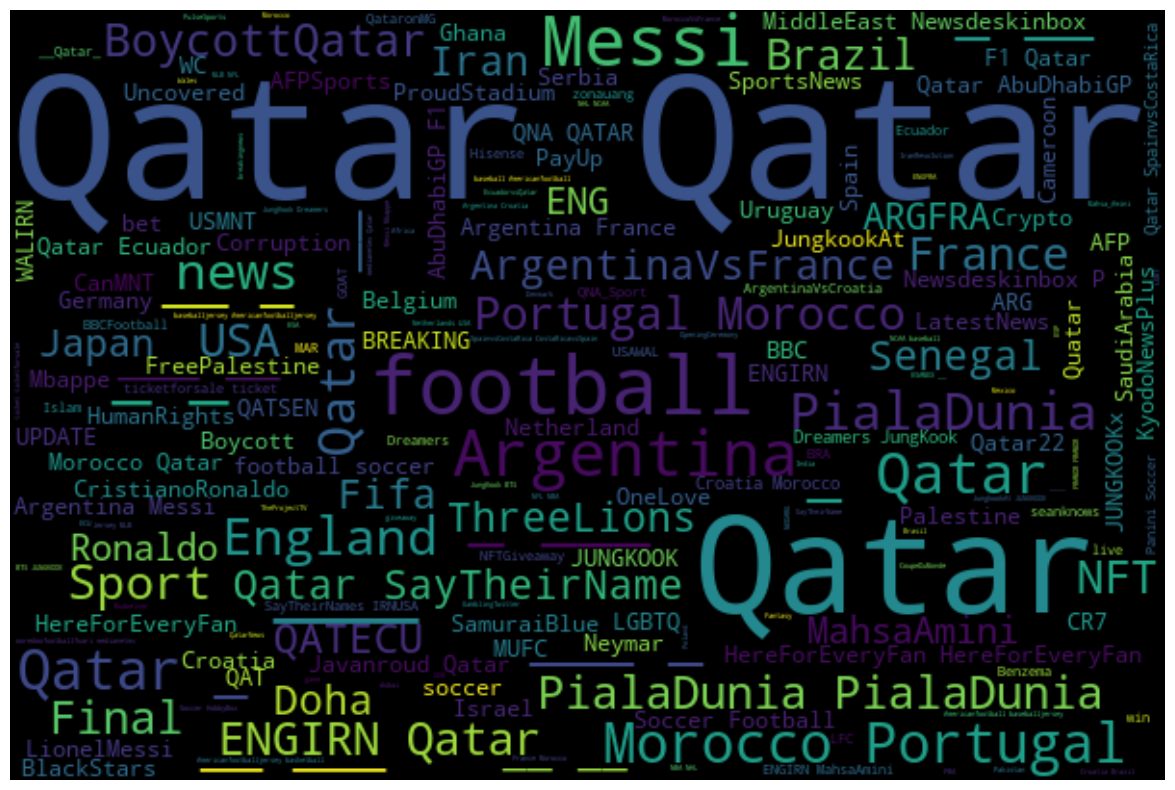

In [33]:
wordcloud = WordCloud(
    width=600,
    height=400,
    random_state=1,
)
data = twitter['Hashtag']
text_data = ' '.join(data)
wordcloud.generate(text_data)
wordcloud.to_image()

all_words_lem = ' '.join([word for word in twitter['Hashtag']])

wordcloud = WordCloud(width=600, 
                     height=400, 
                     random_state=1, 
                     max_font_size=100).generate(all_words_lem)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

### Custom Dataset

In [34]:
twitter

,content,Publisher,Date,Likes,Shares,Hashtag
18924,Paul Pogba miss Qatar due new injury confirm a...,World Cup 2022,2022-11-01,12,1,#Pogba
2774,Qatar face renew pressure migrant worker LGBT ...,Colossus Diplomacy,2022-11-01,0,0,
2775,PUTERA_Miguel Daniel need help work ambitious ...,Blackburn Roverseasson,2022-11-01,0,0,
2776,England boss Gareth Southgate say Qatar worker...,SPORTS CIRCUS INT.,2022-11-01,0,0,
2777,Mikel Arteta Thomas Partey wait happen happy h...,King David,2022-11-01,0,0,
...,...,...,...,...,...,...
9677,Dreamers Music Qatar Official Soundtrack Jung ...,Jungkook Charts,2023-01-31,75,21,#118
9662,700 million years ago Inside Qatar best museum...,Breaking News,2023-01-31,0,0,
9679,Please Qatar bring back,Omar Aldhafiri,2023-01-31,46,10,
9661,Lionel Messi speak length follow historic succ...,Mirror Football,2023-01-31,18,4,


In [35]:
twitter['Date'] = pd.to_datetime(twitter['Date'])

pre_tournament = twitter[twitter['Date'] < '2022-11-20']
tournament = twitter[(twitter['Date'] >= '2022-11-20') & (twitter['Date'] <= '2022-12-18')]
post_tournament = twitter[twitter['Date'] > '2022-12-18']

pre_tournament = pd.DataFrame(pre_tournament)
tournament = pd.DataFrame(tournament)
post_tournament = pd.DataFrame(post_tournament)

/var/folders/90/8rv49pjx7111pvk_g8scvky40000gn/T/ipykernel_6814/1875207493.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter['Date'] = pd.to_datetime(twitter['Date'])


In [36]:
pre_tournament['Date'] = pd.to_datetime(pre_tournament['Date'])
pre_tournament_sorted = pre_tournament.sort_values(by=['Date', 'Likes'], ascending=[True, False])
pre_tournament_likes = pre_tournament_sorted.groupby('Date').head(3)

#pre_tournament_likes.head()

In [37]:
pre_tournament['Date'] = pd.to_datetime(pre_tournament['Date'])
pre_tournament_sorted = pre_tournament.sort_values(by=['Date', 'Shares'], ascending=[True, False])
pre_tournament_shares = pre_tournament_sorted.groupby('Date').head(3)

#pre_tournament_shares.head()

In [38]:
tournament['Date'] = pd.to_datetime(tournament['Date'])
tournament_sorted = tournament.sort_values(by=['Date', 'Likes'], ascending=[True, False])
tournament_likes = tournament_sorted.groupby('Date').head(3)

#tournament_likes.head()

In [39]:
tournament['Date'] = pd.to_datetime(tournament['Date'])
tournament_sorted = tournament.sort_values(by=['Date', 'Shares'], ascending=[True, False])
tournament_shares = tournament_sorted.groupby('Date').head(3)

#tournament_shares.head()

In [40]:
post_tournament['Date'] = pd.to_datetime(post_tournament['Date'])
post_tournament_sorted = post_tournament.sort_values(by=['Date', 'Likes'], ascending=[True, False])
post_tournament_likes = post_tournament_sorted.groupby('Date').head(3)

#post_tournament_likes.head()

In [41]:
post_tournament['Date'] = pd.to_datetime(post_tournament['Date'])
post_tournament_sorted = post_tournament.sort_values(by=['Date', 'Shares'], ascending=[True, False])
post_tournament_shares = post_tournament_sorted.groupby('Date').head(3)

#post_tournament_shares.head()

### Data Modelling

In [42]:
'''
X = twitter['content']

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(X)

num_clusters = 5  

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_tfidf)

cluster_labels = kmeans.labels_

twitter['cluster'] = cluster_labels
'''

"\nX = twitter['content']\n\ntfidf_vectorizer = TfidfVectorizer(max_features=1000)\nX_tfidf = tfidf_vectorizer.fit_transform(X)\n\nnum_clusters = 5  \n\nkmeans = KMeans(n_clusters=num_clusters, random_state=42)\nkmeans.fit(X_tfidf)\n\ncluster_labels = kmeans.labels_\n\ntwitter['cluster'] = cluster_labels\n"

In [43]:
'''
cluster_sum = twitter.groupby(["cluster"]).count()
fig, ax = plt.subplots(figsize=(4, 4))
plt.bar(cluster_sum.index, cluster_sum["content"].values)
plt.show()
'''

'\ncluster_sum = twitter.groupby(["cluster"]).count()\nfig, ax = plt.subplots(figsize=(4, 4))\nplt.bar(cluster_sum.index, cluster_sum["content"].values)\nplt.show()\n'

In [44]:
polarity = []
subjectivity = []

for text in twitter["content"]: 
    polarity.append(TextBlob(text).sentiment.polarity) 
    subjectivity.append(TextBlob(text).sentiment.subjectivity)

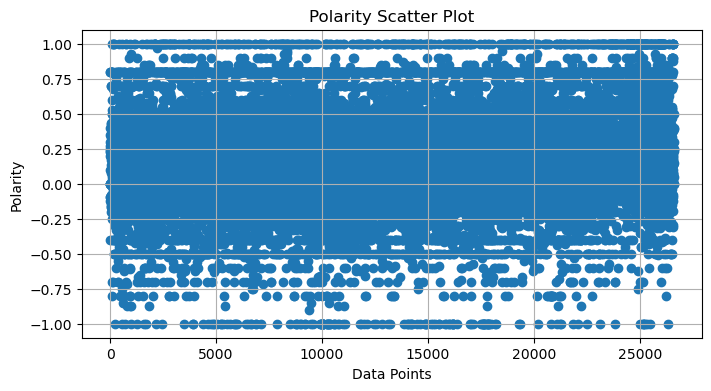

In [45]:
plt.figure(figsize=(8, 4))
plt.scatter(range(len(polarity)), polarity, label='Polarity')
plt.xlabel('Data Points')
plt.ylabel('Polarity')
plt.title('Polarity Scatter Plot')
plt.grid(True)

### Player Analysis

In [46]:
player_df = pd.read_csv("player_stats.csv")

players = player_df[['player']]

In [47]:
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return ''.join([c for c in nfkd_form if not unicodedata.combining(c)])

players['player'] = players['player'].apply(remove_accents)

/var/folders/90/8rv49pjx7111pvk_g8scvky40000gn/T/ipykernel_6814/2412969623.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players['player'] = players['player'].apply(remove_accents)


In [48]:
def extract_surname(full_name):
    names = full_name.split()
    return names[-1]

players['Name'] = players['player'].apply(extract_surname)

player_counts = {}
for player in players['Name']:
    count = twitter['content'].str.count(player).sum()
    player_counts[player] = count

/var/folders/90/8rv49pjx7111pvk_g8scvky40000gn/T/ipykernel_6814/2473252503.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players['Name'] = players['player'].apply(extract_surname)


In [49]:
player_counts = pd.DataFrame.from_dict(player_counts, orient='index', columns=['Count'])
player_counts = player_counts.sort_values(by='Count', ascending=False)
player_counts

,Count
Messi,936
Ronaldo,356
David,240
Mbappe,179
Costa,132
...,...
Kaye,0
Pasalic,0
Chacon,0
Llorente,0


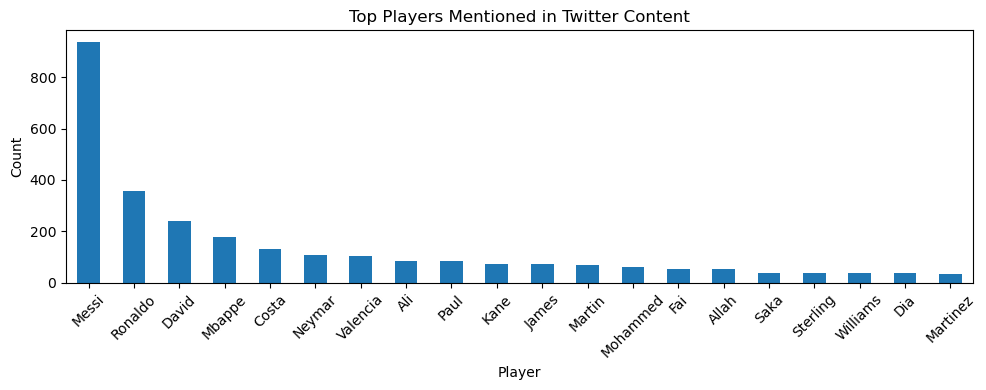

In [50]:
top_players = player_counts.head(20)

fig, ax = plt.subplots(figsize=(10, 4))
top_players.plot(kind='bar', ax=ax, legend=False)
ax.set_ylabel('Count')
ax.set_xlabel('Player')
ax.set_title('Top Players Mentioned in Twitter Content')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Team Analysis

In [51]:
team_df = pd.read_csv("player_stats.csv")
team = team_df[['team']]

In [52]:
unique_teams = team['team'].unique()
unique_teams = [team.replace('IR Iran', 'Iran').replace('Korea Republic', 'Korea').replace('Saudi Arabia', 'Saudi').replace('Costa Rica', 'Costa').replace('United States', 'USA') for team in unique_teams]

### Pre-Tournament

In [53]:
team_counts = {team: 0 for team in unique_teams}

for team in unique_teams:
    team_counts[team] = pre_tournament['content'].str.count(team.lower()).sum()

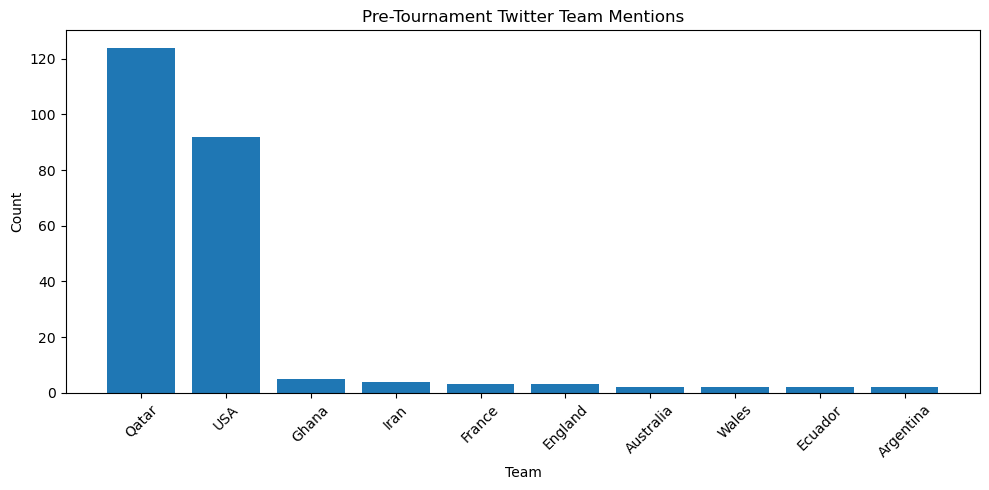

In [54]:
sorted_team_counts = {k: v for k, v in sorted(team_counts.items(), key=lambda item: item[1], reverse=True)}

top_10_teams = list(sorted_team_counts.keys())[0:10]
top_10_counts = list(sorted_team_counts.values())[0:10]

plt.figure(figsize=(10, 5))
plt.bar(top_10_teams, top_10_counts)
plt.xlabel('Team')
plt.ylabel('Count')
plt.title('Pre-Tournament Twitter Team Mentions')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### Tournament

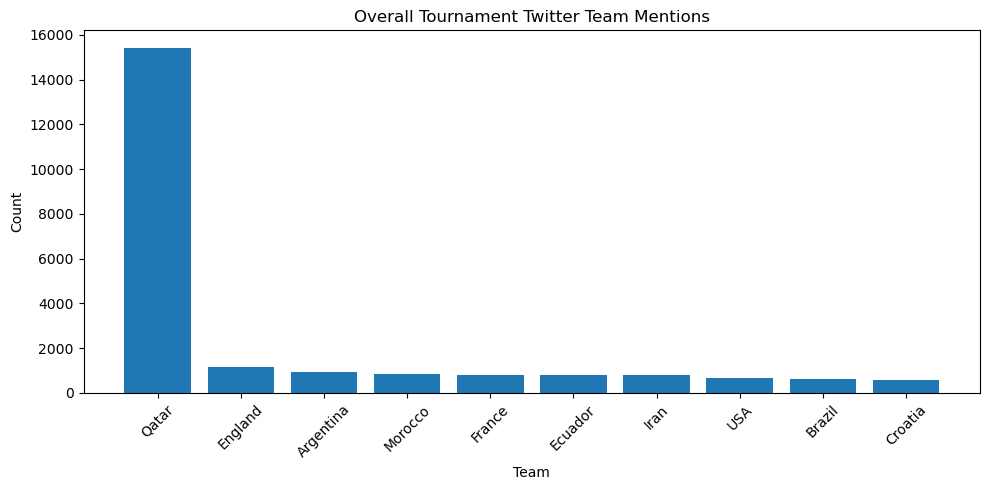

In [55]:
start_date = '2022-11-20'
end_date = '2022-12-18'

filtered_tournament = tournament[(tournament['Date'] >= start_date) & (tournament['Date'] <= end_date)]

team_counts = {team: 0 for team in unique_teams}

filtered_tournament['content'] = filtered_tournament['content'].str.lower()

for team in unique_teams:
    team_counts[team] = filtered_tournament['content'].str.count(team.lower()).sum()

sorted_team_counts = {k: v for k, v in sorted(team_counts.items(), key=lambda item: item[1], reverse=True)}

top_10_teams = list(sorted_team_counts.keys())[:10]
top_10_counts = list(sorted_team_counts.values())[:10]

plt.figure(figsize=(10, 5))
plt.bar(top_10_teams, top_10_counts)
plt.xlabel('Team')
plt.ylabel('Count')
plt.title('Overall Tournament Twitter Team Mentions')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

/var/folders/90/8rv49pjx7111pvk_g8scvky40000gn/T/ipykernel_6814/496089023.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_tournament['content'] = filtered_tournament['content'].str.lower()


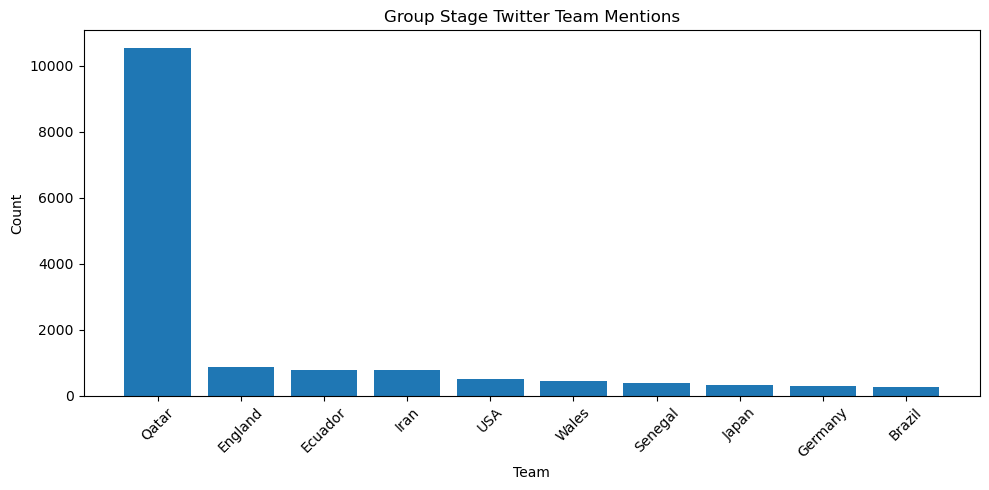

In [56]:
start_date = '2022-11-20'
end_date = '2022-12-2'

filtered_tournament = tournament[(tournament['Date'] >= start_date) & (tournament['Date'] <= end_date)]

team_counts = {team: 0 for team in unique_teams}

filtered_tournament['content'] = filtered_tournament['content'].str.lower()

for team in unique_teams:
    team_counts[team] = filtered_tournament['content'].str.count(team.lower()).sum()

sorted_team_counts = {k: v for k, v in sorted(team_counts.items(), key=lambda item: item[1], reverse=True)}

top_10_teams = list(sorted_team_counts.keys())[:10]
top_10_counts = list(sorted_team_counts.values())[:10]

plt.figure(figsize=(10, 5))
plt.bar(top_10_teams, top_10_counts)
plt.xlabel('Team')
plt.ylabel('Count')
plt.title('Group Stage Twitter Team Mentions')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

/var/folders/90/8rv49pjx7111pvk_g8scvky40000gn/T/ipykernel_6814/2918462821.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_tournament['content'] = filtered_tournament['content'].str.lower()


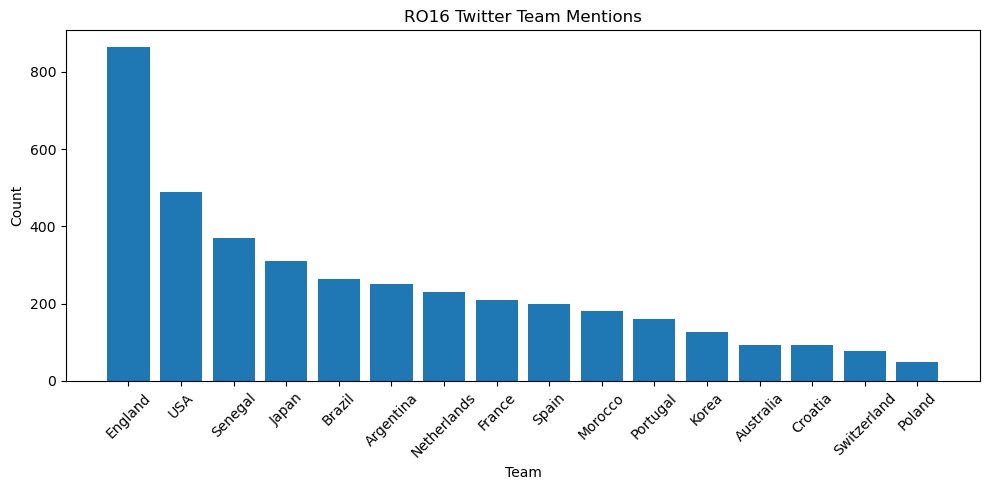

In [57]:
start_date = '2022-12-3'
end_date = '2022-12-7'

teams_of_interest = ['Netherlands', 'USA', 'Argentina', 'Australia', 'Japan', 'Croatia', 
                    'Brazil', 'Korea', 'England', 'Senegal', 'France', 'Poland', 'Morocco',
                    'Spain', 'Portugal', 'Switzerland']

team_counts = {team: 0 for team in teams_of_interest}

filtered_tournament['content'] = filtered_tournament['content'].str.lower()

for team in teams_of_interest:
    team_counts[team] = filtered_tournament['content'].str.count(team.lower()).sum()

sorted_team_counts = {k: v for k, v in sorted(team_counts.items(), key=lambda item: item[1], reverse=True)}

RO16_teams = list(sorted_team_counts.keys())[:len(teams_of_interest)]
RO16_counts = list(sorted_team_counts.values())[:len(teams_of_interest)]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(RO16_teams, RO16_counts)
plt.xlabel('Team')
plt.ylabel('Count')
plt.title('RO16 Twitter Team Mentions')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

/var/folders/90/8rv49pjx7111pvk_g8scvky40000gn/T/ipykernel_6814/4235212796.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_tournament['content'] = filtered_tournament['content'].str.lower()


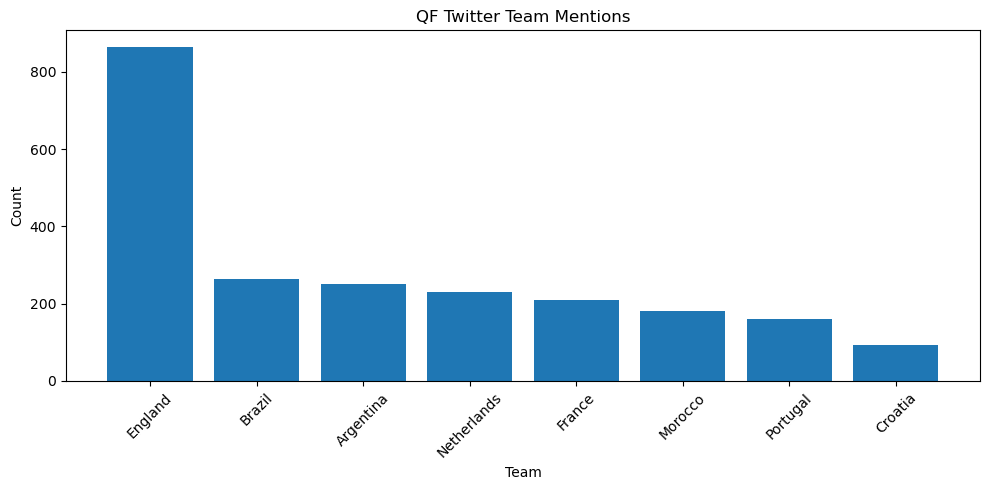

In [58]:
start_date = '2022-12-9'
end_date = '2022-12-11'

teams_of_interest = ['Netherlands', 'Argentina', 'Croatia', 'Brazil', 'England', 'France', 'Morocco', 'Portugal']

team_counts = {team: 0 for team in teams_of_interest}

filtered_tournament['content'] = filtered_tournament['content'].str.lower()

for team in teams_of_interest:
    team_counts[team] = filtered_tournament['content'].str.count(team.lower()).sum()

sorted_team_counts = {k: v for k, v in sorted(team_counts.items(), key=lambda item: item[1], reverse=True)}

QF_teams = list(sorted_team_counts.keys())[:len(teams_of_interest)]
QF_counts = list(sorted_team_counts.values())[:len(teams_of_interest)]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(QF_teams, QF_counts)
plt.xlabel('Team')
plt.ylabel('Count')
plt.title('QF Twitter Team Mentions')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

/var/folders/90/8rv49pjx7111pvk_g8scvky40000gn/T/ipykernel_6814/634407326.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_tournament['content'] = filtered_tournament['content'].str.lower()


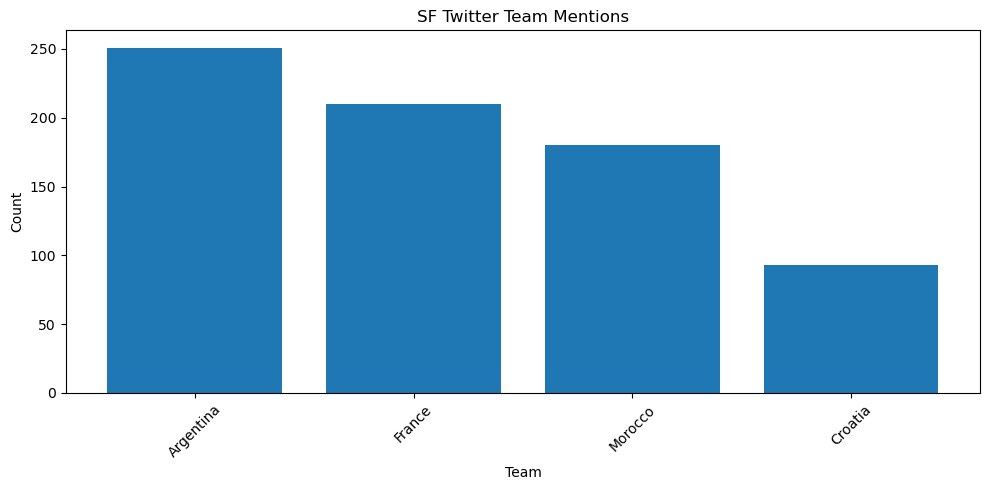

In [59]:
start_date = '2022-12-13'
end_date = '2022-12-15'

teams_of_interest = ['Argentina', 'Croatia', 'France', 'Morocco']

team_counts = {team: 0 for team in teams_of_interest}

filtered_tournament['content'] = filtered_tournament['content'].str.lower()

for team in teams_of_interest:
    team_counts[team] = filtered_tournament['content'].str.count(team.lower()).sum()

sorted_team_counts = {k: v for k, v in sorted(team_counts.items(), key=lambda item: item[1], reverse=True)}

SF_teams = list(sorted_team_counts.keys())[:len(teams_of_interest)]
SF_counts = list(sorted_team_counts.values())[:len(teams_of_interest)]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(SF_teams, SF_counts)
plt.xlabel('Team')
plt.ylabel('Count')
plt.title('SF Twitter Team Mentions')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### Post-Tournament

In [60]:
team_counts = {team: 0 for team in unique_teams}

for team in unique_teams:
    team_counts[team] = post_tournament['content'].str.count(team.lower()).sum()

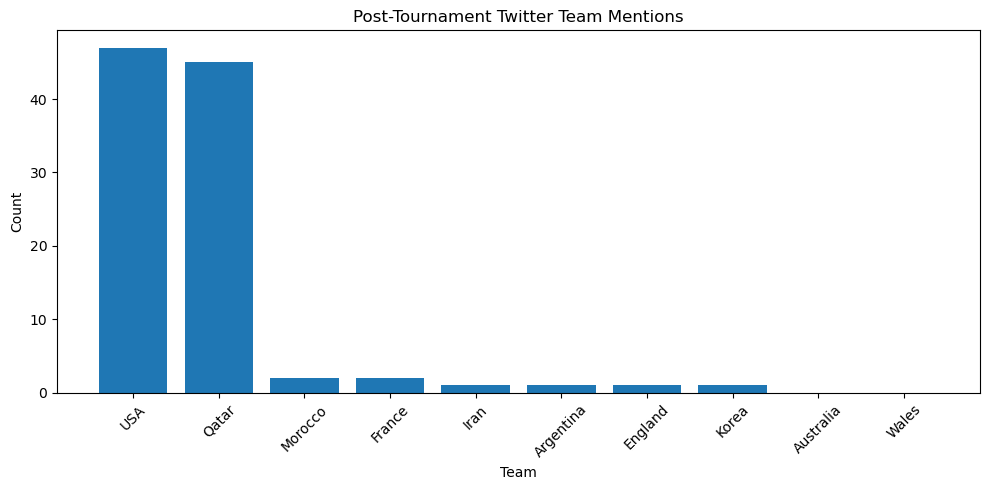

In [61]:
sorted_team_counts = {k: v for k, v in sorted(team_counts.items(), key=lambda item: item[1], reverse=True)}

top_10_teams = list(sorted_team_counts.keys())[:10]
top_10_counts = list(sorted_team_counts.values())[:10]

plt.figure(figsize=(10, 5))
plt.bar(top_10_teams, top_10_counts)
plt.xlabel('Team')
plt.ylabel('Count')
plt.title('Post-Tournament Twitter Team Mentions')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [62]:
'''
GS1: 20/11 - 24/11
GS2: 25/11 - 28/11
GS3: 29/11 - 2/12
RO16: 3/12 - 6/12
QF: 9/12 - 10/12
SF: 13/12 - 14/12
3P: 17/12
F: 18/12
'''

'\nGS1: 20/11 - 24/11\nGS2: 25/11 - 28/11\nGS3: 29/11 - 2/12\nRO16: 3/12 - 6/12\nQF: 9/12 - 10/12\nSF: 13/12 - 14/12\n3P: 17/12\nF: 18/12\n'

### Sentiment Analysis

In [63]:
nltk.download('movie_reviews')
nltk.download('vader_lexicon')

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/farrelw/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/farrelw/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [69]:
# Create a function to get sentiment polarity using TextBlob
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply sentiment analysis to the 'content' column and store the results in a new column 'sentiment_score'
twitter['Sentiment_Score'] = twitter['content'].apply(get_sentiment)

In [70]:
twitter = twitter.sort_values(by=['Sentiment_Score'], ascending=False)
twitter.head(26591)

,content,Publisher,Date,Likes,Shares,Hashtag,Sentiment Score,Sentiment_Score
25586,think Qatar awesome,SCORPION X,2022-12-09,0,0,,1.0,1.0
10836,President Gianni Infantino BeIN Sports Qatar b...,Get French Football News,2022-11-20,141,14,,1.0,1.0
8726,Best Players Enna Valencia score twice Ecuador...,iChongqing,2022-11-21,6,1,#Qatar # #,1.0,1.0
3318,mascot make Qatar team us host best ever never...,"Yeah yeah, I know",2022-11-20,0,0,,1.0,1.0
1761,Fifa Infantino hail Qatar best ever tcoGkF3HvsuKp,Shuaib Mahomed,2022-12-17,0,0,,1.0,1.0
...,...,...,...,...,...,...,...,...
21098,invite com go worst ever football show money a...,alicio silva,2022-11-19,0,0,#qatar,-1.0,-1.0
25599,Mo Salah Erling Haaland insane XI players nt m...,Sun Sport,2022-11-27,2,0,,-1.0,-1.0
20514,Ghana goalkeeper Joe Wollacott get chance go e...,Reuters Sports,2022-11-19,1,0,,-1.0,-1.0
3867,Security force Qatar harass people wear Tshirt...,Dr. Iman Taheri,2022-11-29,943,585,#Qatar #WomanLifeFreedom #MahsaAmini,-1.0,-1.0


In [71]:
average_sentiment_scores = {'Country': [], 'Average_Sentiment_Score': []}

for country in unique_teams:
    country_data = twitter[twitter['content'].str.contains(country, case=False)]
    
    average_sentiment_score = country_data['Sentiment_Score'].mean()
    
    average_sentiment_scores['Country'].append(country)
    average_sentiment_scores['Average_Sentiment_Score'].append(average_sentiment_score)

avg_sentiment = pd.DataFrame(average_sentiment_scores)

In [72]:
avg_sentiment = avg_sentiment.sort_values(by='Average_Sentiment_Score', ascending=False)
avg_sentiment = avg_sentiment.reset_index(drop=True)

avg_sentiment

,Country,Average_Sentiment_Score
0,Serbia,0.258443
1,Argentina,0.222221
2,Brazil,0.211419
3,Morocco,0.199563
4,Japan,0.179274
5,Costa,0.178437
6,Belgium,0.172834
7,Spain,0.167268
8,Portugal,0.166376
9,Saudi,0.158429


In [95]:
positive_threshold = 0.05
negative_threshold = -0.05
ex_positive_threshold = 0.5
ex_negative_threshold = -0.5

def categorize_sentiment(score):
    if score > ex_positive_threshold:
        return 'Extremely Positive'
    elif score > positive_threshold:
        return 'Positive'
    elif score < ex_negative_threshold:
        return 'Extremely Negative'
    elif score < negative_threshold:
        return 'Negative'
    else:
        return 'Neutral'

twitter['Sentiment_Category'] = twitter['Sentiment_Score'].apply(categorize_sentiment)
sentiment_counts = twitter['Sentiment_Category'].value_counts()

sentiment_counts

Positive              10052
Neutral                9704
Negative               3470
Extremely Positive     2921
Extremely Negative      444
Name: Sentiment_Category, dtype: int64

In [96]:
sentiment_breakdowns = {'Country': [], 'Extremely Positive': [], 'Positive': [], 'Neutral': [], 'Negative': [], 'Extremely Negative': [],}

for country in unique_teams:
    country_data = twitter[twitter['content'].str.contains(country, case=False)]
    
    ex_positive_count = (country_data['Sentiment_Category'] == 'Extremely Positive').sum()
    positive_count = (country_data['Sentiment_Category'] == 'Positive').sum()
    neutral_count = (country_data['Sentiment_Category'] == 'Neutral').sum()
    negative_count = (country_data['Sentiment_Category'] == 'Negative').sum()
    ex_negative_count = (country_data['Sentiment_Category'] == 'Extremely Negative').sum()
    
    sentiment_breakdowns['Country'].append(country)
    sentiment_breakdowns['Extremely Positive'].append(ex_positive_count)
    sentiment_breakdowns['Positive'].append(positive_count)
    sentiment_breakdowns['Neutral'].append(neutral_count)
    sentiment_breakdowns['Negative'].append(negative_count)
    sentiment_breakdowns['Extremely Negative'].append(ex_negative_count)

sentiment_breakdown = pd.DataFrame(sentiment_breakdowns)

sentiment_breakdown['Total'] = sentiment_breakdown['Extremely Positive'] + sentiment_breakdown['Positive'] + sentiment_breakdown['Neutral'] + sentiment_breakdown['Negative'] + sentiment_breakdown['Extremely Negative']
sentiment_breakdown['Extremely Positive %'] = ((sentiment_breakdown['Extremely Positive'] / sentiment_breakdown['Total']) * 100).round(1)
sentiment_breakdown['Positive %'] = ((sentiment_breakdown['Positive'] / sentiment_breakdown['Total']) * 100).round(1)
sentiment_breakdown['Negative %'] = ((sentiment_breakdown['Negative'] / sentiment_breakdown['Total']) * 100).round(1)
sentiment_breakdown['Neutral %'] = ((sentiment_breakdown['Neutral'] / sentiment_breakdown['Total']) * 100).round(1)
sentiment_breakdown['Extremely Negative %'] = ((sentiment_breakdown['Extremely Negative'] / sentiment_breakdown['Total']) * 100).round(1)

sentiment_breakdown

,Country,Extremely Positive,Positive,Neutral,Negative,Extremely Negative,Total,Extremely Positive %,Positive %,Negative %,Neutral %,Extremely Negative %
0,Australia,17,95,57,31,3,203,8.4,46.8,15.3,28.1,1.5
1,Wales,31,191,179,63,9,473,6.6,40.4,13.3,37.8,1.9
2,Morocco,90,410,220,47,2,769,11.7,53.3,6.1,28.6,0.3
3,Qatar,2328,8465,8289,3102,418,22602,10.3,37.5,13.7,36.7,1.8
4,Senegal,47,192,152,48,6,445,10.6,43.1,10.8,34.2,1.3
5,Ghana,19,107,92,56,6,280,6.8,38.2,20.0,32.9,2.1
6,Saudi,40,113,104,41,5,303,13.2,37.3,13.5,34.3,1.7
7,Iran,40,237,250,126,12,665,6.0,35.6,18.9,37.6,1.8
8,France,93,397,322,92,8,912,10.2,43.5,10.1,35.3,0.9
9,Uruguay,13,54,45,17,3,132,9.8,40.9,12.9,34.1,2.3
